# Model training.

[Dataset](https://github.com/imesluh/vocalfolds)


In [1]:
import os

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

In [2]:
import torch
from glob import glob
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
import random
from Uformer import modelIdentityAndAtt
from losses import losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR

In [3]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 2060 SUPER')

In [4]:
SEED = 33
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)

In [5]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CLASSES = 7
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 1e-4
WEIGHT_DECAY = 1e-8
NUM_EPOCHS = 100
BATCH_SIZE = 32
# define the input image dimensions
INPUT_IMAGE_WIDTH = 64
INPUT_IMAGE_HEIGHT = 64

## Data preparation.

In [6]:
IMAGE_DATASET_PATH = glob('../../vocalfolds/img/*/*/*.png')
MASK_DATASET_PATH  = glob('../../vocalfolds/annot/*/*/*.png')

N = len(IMAGE_DATASET_PATH)
assert len(IMAGE_DATASET_PATH) == len(MASK_DATASET_PATH)

print(f'Number of samples: {str(len(MASK_DATASET_PATH))}')

Number of samples: 536


In [7]:
# https://gist.github.com/IdeaKing/11cf5e146d23c5bb219ba3508cca89ec
def resize_with_pad(image: np.array, 
                    new_shape, 
                    padding_color = (0, 0, 0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [8]:
def to_categorical(y, num_classes=None, dtype="float32"):
	y = np.array(y, dtype="int")
	input_shape = y.shape

	# Shrink the last dimension if the shape is (..., 1).
	if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
		input_shape = tuple(input_shape[:-1])

	y = y.reshape(-1)
	if not num_classes:
		num_classes = np.max(y) + 1
	n = y.shape[0]
	categorical = np.zeros((n, num_classes), dtype=dtype)
	categorical[np.arange(n), y] = 1
	output_shape = input_shape + (num_classes,)
	categorical = np.reshape(categorical, output_shape)
	return categorical

labels = [[0],[1],[2],[3],[4],[5],[6]]
def encode_mask(masks_arr, n_classes=NUM_CLASSES, H=INPUT_IMAGE_HEIGHT, W=INPUT_IMAGE_WIDTH, labels_arr=labels):
    y_encoded = np.zeros((H, W, 1), dtype=np.uint8)

    for i, label in enumerate(labels_arr):
        y_encoded[np.all(label == masks_arr, axis=-1)] = i
    
    return to_categorical(y_encoded, num_classes=n_classes)

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image / 255
		image = torch.from_numpy(np.float32(image))
		image = image.permute(2,0,1)

		mask = cv2.imread(self.maskPaths[idx])
		mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (0, 0, 0))
		mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
		mask = np.expand_dims(mask, axis=-1)
		mask = encode_mask(mask)
		mask = torch.from_numpy(np.float32(mask))
		mask = mask.permute(2,0,1)

		assert image.shape == (3, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad image shape {image.shape}"
		assert mask.shape == (NUM_CLASSES, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad mask shape {mask.shape}"

		# return a tuple of the image and its mask
		return image, mask

In [9]:
uformer = modelIdentityAndAtt.Uformer(img_size=INPUT_IMAGE_HEIGHT,in_chans=NUM_CLASSES, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
trainImages, testImages, trainMasks, testMasks = train_test_split(IMAGE_DATASET_PATH, MASK_DATASET_PATH, test_size=0.2, random_state=43)

c:\Users\alexg\miniconda3\envs\pytorch-gpu\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
# define transformations
from torch.utils.data import DataLoader

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
num_workers = 4
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

trainLoader = DataLoader(
	trainDS, 
	shuffle=True,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)
testLoader = DataLoader(
	testDS, shuffle=False,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)

[INFO] found 428 examples in the training set...
[INFO] found 108 examples in the test set...


In [11]:
uformer = uformer.to(DEVICE)
softmax = torch.nn.Softmax(1)
# initialize loss function and optimizer
lossFunc = losses.CombinedLoss().cuda()
opt = torch.optim.Adam(uformer.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=WEIGHT_DECAY)
iouMetric = losses.MeanIoU().cuda()
gdlMetric = losses.DiceCoeficient().cuda()

# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE + 1
testSteps = len(testDS) // BATCH_SIZE + 1

scheduler = CosineAnnealingLR(opt, T_max=trainSteps*NUM_EPOCHS)

# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "train_IoU": [], "test_IoU": [],"train_DC": [], "test_DC": []}

In [12]:
bestIoU = 0
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in range(NUM_EPOCHS):
	# torch.cuda.empty_cache()
	# set the model in training mode
	uformer.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0

	totalTrainIoU = 0
	totalTestIoU = 0
	totalTrainDC = 0
	totalTestDC = 0
	# loop over the training set
	for i, (x, y) in enumerate(tqdm(trainLoader)):
		# send the input to the device
		x, y = x.to(DEVICE), y.to(DEVICE)
		# perform a forward pass and calculate the training loss
		pred = uformer(x)
		assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
		pred = softmax(pred)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		scheduler.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
		totalTrainIoU += iouMetric(pred, y)
		totalTrainDC += gdlMetric(pred, y)
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		uformer.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = uformer(x)
			assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
			pred = softmax(pred)
			totalTestLoss += lossFunc(pred, y)
			totalTestIoU += iouMetric(pred, y)
			totalTestDC += gdlMetric(pred, y)
			
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps

	avgTrainIoU = totalTrainIoU / trainSteps
	avgTestIoU = totalTestIoU / testSteps
	avgTrainDC = totalTrainDC / trainSteps
	avgTestDC = totalTestDC / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

	H["train_IoU"].append(avgTrainIoU.cpu().detach().numpy())
	H["test_IoU"].append(avgTestIoU.cpu().detach().numpy())
	H["train_DC"].append(avgTrainDC.cpu().detach().numpy())
	H["test_DC"].append(avgTestDC.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print(f"Train loss: {avgTrainLoss:.6f}, Test loss: {avgTestLoss:.4f}, " + 
       f"Train IoU: {avgTrainIoU:.4f}, Test IoU: {avgTestIoU:.4f}, Train Dice: {avgTrainDC:.4f}, Test Dice: {avgTestDC:.4f}")
	
	if avgTestIoU > bestIoU:
		bestIoU = avgTestIoU
		torch.save(uformer.state_dict(), '../models/VF_uformeridentityandatt.pth')
		print('Best IoU improved. Model saved.')
		
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))
print(f'Best IoU is: {bestIoU:.5f}')

[INFO] training the network...


100%|██████████| 14/14 [00:07<00:00,  1.95it/s]


[INFO] EPOCH: 1/100
Train loss: 2.893641, Test loss: 2.8497, Train IoU: 0.1516, Test IoU: 0.1844, Train Dice: 0.2573, Test Dice: 0.3098
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.88it/s]


[INFO] EPOCH: 2/100
Train loss: 2.824931, Test loss: 2.8131, Train IoU: 0.2024, Test IoU: 0.2106, Train Dice: 0.3321, Test Dice: 0.3463
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.89it/s]


[INFO] EPOCH: 3/100
Train loss: 2.787439, Test loss: 2.7747, Train IoU: 0.2298, Test IoU: 0.2398, Train Dice: 0.3699, Test Dice: 0.3852
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.89it/s]


[INFO] EPOCH: 4/100
Train loss: 2.751467, Test loss: 2.7307, Train IoU: 0.2586, Test IoU: 0.2743, Train Dice: 0.4063, Test Dice: 0.4288
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.88it/s]


[INFO] EPOCH: 5/100
Train loss: 2.705233, Test loss: 2.6774, Train IoU: 0.2957, Test IoU: 0.3183, Train Dice: 0.4526, Test Dice: 0.4813
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.86it/s]


[INFO] EPOCH: 6/100
Train loss: 2.648473, Test loss: 2.6440, Train IoU: 0.3450, Test IoU: 0.3490, Train Dice: 0.5091, Test Dice: 0.5164
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.89it/s]


[INFO] EPOCH: 7/100
Train loss: 2.598364, Test loss: 2.5525, Train IoU: 0.3927, Test IoU: 0.4389, Train Dice: 0.5604, Test Dice: 0.6078
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.90it/s]


[INFO] EPOCH: 8/100
Train loss: 2.531089, Test loss: 2.5117, Train IoU: 0.4625, Test IoU: 0.4826, Train Dice: 0.6280, Test Dice: 0.6497
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.85it/s]


[INFO] EPOCH: 9/100
Train loss: 2.500755, Test loss: 2.4819, Train IoU: 0.4954, Test IoU: 0.5163, Train Dice: 0.6592, Test Dice: 0.6798
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.87it/s]


[INFO] EPOCH: 10/100
Train loss: 2.478168, Test loss: 2.4689, Train IoU: 0.5209, Test IoU: 0.5319, Train Dice: 0.6822, Test Dice: 0.6928
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.85it/s]


[INFO] EPOCH: 11/100
Train loss: 2.454558, Test loss: 2.4437, Train IoU: 0.5496, Test IoU: 0.5620, Train Dice: 0.7066, Test Dice: 0.7182
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.85it/s]


[INFO] EPOCH: 12/100
Train loss: 2.441269, Test loss: 2.4254, Train IoU: 0.5654, Test IoU: 0.5849, Train Dice: 0.7197, Test Dice: 0.7367
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.87it/s]


[INFO] EPOCH: 13/100
Train loss: 2.418697, Test loss: 2.4257, Train IoU: 0.5942, Test IoU: 0.5847, Train Dice: 0.7424, Test Dice: 0.7367


100%|██████████| 14/14 [00:04<00:00,  2.86it/s]


[INFO] EPOCH: 14/100
Train loss: 2.419402, Test loss: 2.4233, Train IoU: 0.5931, Test IoU: 0.5884, Train Dice: 0.7421, Test Dice: 0.7390
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.86it/s]


[INFO] EPOCH: 15/100
Train loss: 2.415127, Test loss: 2.4031, Train IoU: 0.5983, Test IoU: 0.6134, Train Dice: 0.7465, Test Dice: 0.7592
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.87it/s]


[INFO] EPOCH: 16/100
Train loss: 2.389028, Test loss: 2.3914, Train IoU: 0.6329, Test IoU: 0.6286, Train Dice: 0.7729, Test Dice: 0.7711
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


[INFO] EPOCH: 17/100
Train loss: 2.381916, Test loss: 2.4071, Train IoU: 0.6425, Test IoU: 0.6084, Train Dice: 0.7799, Test Dice: 0.7553


100%|██████████| 14/14 [00:04<00:00,  2.85it/s]


[INFO] EPOCH: 18/100
Train loss: 2.378826, Test loss: 2.3783, Train IoU: 0.6471, Test IoU: 0.6466, Train Dice: 0.7831, Test Dice: 0.7844
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


[INFO] EPOCH: 19/100
Train loss: 2.370904, Test loss: 2.3930, Train IoU: 0.6573, Test IoU: 0.6276, Train Dice: 0.7912, Test Dice: 0.7696


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 20/100
Train loss: 2.365638, Test loss: 2.3808, Train IoU: 0.6648, Test IoU: 0.6430, Train Dice: 0.7965, Test Dice: 0.7821


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 21/100
Train loss: 2.355872, Test loss: 2.3623, Train IoU: 0.6785, Test IoU: 0.6684, Train Dice: 0.8064, Test Dice: 0.8005
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 22/100
Train loss: 2.344420, Test loss: 2.3549, Train IoU: 0.6949, Test IoU: 0.6792, Train Dice: 0.8179, Test Dice: 0.8081
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


[INFO] EPOCH: 23/100
Train loss: 2.348553, Test loss: 2.3539, Train IoU: 0.6892, Test IoU: 0.6806, Train Dice: 0.8140, Test Dice: 0.8091
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.86it/s]


[INFO] EPOCH: 24/100
Train loss: 2.339667, Test loss: 2.3548, Train IoU: 0.7019, Test IoU: 0.6795, Train Dice: 0.8229, Test Dice: 0.8082


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 25/100
Train loss: 2.339932, Test loss: 2.3502, Train IoU: 0.7014, Test IoU: 0.6859, Train Dice: 0.8227, Test Dice: 0.8129
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 26/100
Train loss: 2.326078, Test loss: 2.3464, Train IoU: 0.7215, Test IoU: 0.6914, Train Dice: 0.8368, Test Dice: 0.8167
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 27/100
Train loss: 2.327963, Test loss: 2.3484, Train IoU: 0.7188, Test IoU: 0.6883, Train Dice: 0.8349, Test Dice: 0.8148


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


[INFO] EPOCH: 28/100
Train loss: 2.325998, Test loss: 2.3411, Train IoU: 0.7220, Test IoU: 0.6992, Train Dice: 0.8367, Test Dice: 0.8220
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.85it/s]


[INFO] EPOCH: 29/100
Train loss: 2.317650, Test loss: 2.3396, Train IoU: 0.7348, Test IoU: 0.7011, Train Dice: 0.8452, Test Dice: 0.8237
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 30/100
Train loss: 2.311983, Test loss: 2.3315, Train IoU: 0.7432, Test IoU: 0.7132, Train Dice: 0.8508, Test Dice: 0.8317
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 31/100
Train loss: 2.308653, Test loss: 2.3293, Train IoU: 0.7482, Test IoU: 0.7165, Train Dice: 0.8544, Test Dice: 0.8339
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 32/100
Train loss: 2.306327, Test loss: 2.3319, Train IoU: 0.7518, Test IoU: 0.7125, Train Dice: 0.8568, Test Dice: 0.8313


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 33/100
Train loss: 2.304584, Test loss: 2.3247, Train IoU: 0.7546, Test IoU: 0.7231, Train Dice: 0.8584, Test Dice: 0.8386
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 34/100
Train loss: 2.299882, Test loss: 2.3242, Train IoU: 0.7618, Test IoU: 0.7239, Train Dice: 0.8633, Test Dice: 0.8392
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 35/100
Train loss: 2.298254, Test loss: 2.3209, Train IoU: 0.7647, Test IoU: 0.7290, Train Dice: 0.8649, Test Dice: 0.8425
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 36/100
Train loss: 2.295622, Test loss: 2.3262, Train IoU: 0.7687, Test IoU: 0.7211, Train Dice: 0.8676, Test Dice: 0.8370


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 37/100
Train loss: 2.293493, Test loss: 2.3198, Train IoU: 0.7717, Test IoU: 0.7304, Train Dice: 0.8698, Test Dice: 0.8437
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


[INFO] EPOCH: 38/100
Train loss: 2.290393, Test loss: 2.3206, Train IoU: 0.7774, Test IoU: 0.7294, Train Dice: 0.8728, Test Dice: 0.8428


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 39/100
Train loss: 2.286265, Test loss: 2.3187, Train IoU: 0.7832, Test IoU: 0.7323, Train Dice: 0.8770, Test Dice: 0.8447
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 40/100
Train loss: 2.285102, Test loss: 2.3160, Train IoU: 0.7853, Test IoU: 0.7362, Train Dice: 0.8782, Test Dice: 0.8475
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 41/100
Train loss: 2.285394, Test loss: 2.3179, Train IoU: 0.7846, Test IoU: 0.7332, Train Dice: 0.8779, Test Dice: 0.8455


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 42/100
Train loss: 2.282650, Test loss: 2.3129, Train IoU: 0.7892, Test IoU: 0.7408, Train Dice: 0.8807, Test Dice: 0.8505
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 43/100
Train loss: 2.282393, Test loss: 2.3197, Train IoU: 0.7898, Test IoU: 0.7308, Train Dice: 0.8808, Test Dice: 0.8437


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 44/100
Train loss: 2.281087, Test loss: 2.3153, Train IoU: 0.7915, Test IoU: 0.7372, Train Dice: 0.8823, Test Dice: 0.8482


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 45/100
Train loss: 2.278001, Test loss: 2.3126, Train IoU: 0.7966, Test IoU: 0.7414, Train Dice: 0.8854, Test Dice: 0.8509
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 46/100
Train loss: 2.276405, Test loss: 2.3126, Train IoU: 0.7993, Test IoU: 0.7414, Train Dice: 0.8870, Test Dice: 0.8509
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 47/100
Train loss: 2.276928, Test loss: 2.3101, Train IoU: 0.7984, Test IoU: 0.7452, Train Dice: 0.8865, Test Dice: 0.8534
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 48/100
Train loss: 2.274138, Test loss: 2.3115, Train IoU: 0.8028, Test IoU: 0.7433, Train Dice: 0.8894, Test Dice: 0.8521


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 49/100
Train loss: 2.273348, Test loss: 2.3109, Train IoU: 0.8042, Test IoU: 0.7441, Train Dice: 0.8901, Test Dice: 0.8526


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 50/100
Train loss: 2.271270, Test loss: 2.3082, Train IoU: 0.8079, Test IoU: 0.7481, Train Dice: 0.8922, Test Dice: 0.8553
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 51/100
Train loss: 2.271394, Test loss: 2.3075, Train IoU: 0.8074, Test IoU: 0.7493, Train Dice: 0.8921, Test Dice: 0.8561
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 52/100
Train loss: 2.268246, Test loss: 2.3081, Train IoU: 0.8126, Test IoU: 0.7483, Train Dice: 0.8953, Test Dice: 0.8554


100%|██████████| 14/14 [00:05<00:00,  2.80it/s]


[INFO] EPOCH: 53/100
Train loss: 2.269535, Test loss: 2.3070, Train IoU: 0.8105, Test IoU: 0.7500, Train Dice: 0.8941, Test Dice: 0.8565
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 54/100
Train loss: 2.267556, Test loss: 2.3060, Train IoU: 0.8138, Test IoU: 0.7519, Train Dice: 0.8960, Test Dice: 0.8576
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 55/100
Train loss: 2.264789, Test loss: 2.3061, Train IoU: 0.8184, Test IoU: 0.7517, Train Dice: 0.8988, Test Dice: 0.8575


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 56/100
Train loss: 2.264883, Test loss: 2.3061, Train IoU: 0.8180, Test IoU: 0.7511, Train Dice: 0.8987, Test Dice: 0.8573


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 57/100
Train loss: 2.267360, Test loss: 2.3102, Train IoU: 0.8142, Test IoU: 0.7452, Train Dice: 0.8961, Test Dice: 0.8534


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 58/100
Train loss: 2.264045, Test loss: 2.3092, Train IoU: 0.8194, Test IoU: 0.7465, Train Dice: 0.8995, Test Dice: 0.8543


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 59/100
Train loss: 2.262557, Test loss: 2.3053, Train IoU: 0.8220, Test IoU: 0.7527, Train Dice: 0.9010, Test Dice: 0.8582
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 60/100
Train loss: 2.263343, Test loss: 2.3039, Train IoU: 0.8208, Test IoU: 0.7549, Train Dice: 0.9002, Test Dice: 0.8596
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 61/100
Train loss: 2.262165, Test loss: 2.3059, Train IoU: 0.8226, Test IoU: 0.7515, Train Dice: 0.9014, Test Dice: 0.8576


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 62/100
Train loss: 2.260831, Test loss: 2.3045, Train IoU: 0.8248, Test IoU: 0.7539, Train Dice: 0.9028, Test Dice: 0.8591


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 63/100
Train loss: 2.261057, Test loss: 2.3041, Train IoU: 0.8245, Test IoU: 0.7545, Train Dice: 0.9025, Test Dice: 0.8594


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 64/100
Train loss: 2.258214, Test loss: 2.3042, Train IoU: 0.8292, Test IoU: 0.7545, Train Dice: 0.9055, Test Dice: 0.8594


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 65/100
Train loss: 2.259917, Test loss: 2.3029, Train IoU: 0.8266, Test IoU: 0.7562, Train Dice: 0.9037, Test Dice: 0.8606
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 66/100
Train loss: 2.259355, Test loss: 2.3025, Train IoU: 0.8274, Test IoU: 0.7569, Train Dice: 0.9043, Test Dice: 0.8610
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 67/100
Train loss: 2.259515, Test loss: 2.3038, Train IoU: 0.8273, Test IoU: 0.7551, Train Dice: 0.9041, Test Dice: 0.8598


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 68/100
Train loss: 2.257816, Test loss: 2.3026, Train IoU: 0.8303, Test IoU: 0.7566, Train Dice: 0.9058, Test Dice: 0.8609


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 69/100
Train loss: 2.257085, Test loss: 2.3021, Train IoU: 0.8313, Test IoU: 0.7577, Train Dice: 0.9066, Test Dice: 0.8615
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 70/100
Train loss: 2.255760, Test loss: 2.3030, Train IoU: 0.8334, Test IoU: 0.7562, Train Dice: 0.9079, Test Dice: 0.8605


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 71/100
Train loss: 2.257027, Test loss: 2.3020, Train IoU: 0.8317, Test IoU: 0.7578, Train Dice: 0.9066, Test Dice: 0.8615
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 72/100
Train loss: 2.256305, Test loss: 2.3027, Train IoU: 0.8326, Test IoU: 0.7568, Train Dice: 0.9073, Test Dice: 0.8608


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 73/100
Train loss: 2.255614, Test loss: 2.3016, Train IoU: 0.8336, Test IoU: 0.7583, Train Dice: 0.9081, Test Dice: 0.8619
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 74/100
Train loss: 2.254711, Test loss: 2.3019, Train IoU: 0.8352, Test IoU: 0.7581, Train Dice: 0.9090, Test Dice: 0.8616


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 75/100
Train loss: 2.255051, Test loss: 2.3017, Train IoU: 0.8347, Test IoU: 0.7581, Train Dice: 0.9085, Test Dice: 0.8618


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 76/100
Train loss: 2.254215, Test loss: 2.3014, Train IoU: 0.8365, Test IoU: 0.7586, Train Dice: 0.9094, Test Dice: 0.8621
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 77/100
Train loss: 2.254630, Test loss: 2.3035, Train IoU: 0.8353, Test IoU: 0.7553, Train Dice: 0.9090, Test Dice: 0.8601


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 78/100
Train loss: 2.253988, Test loss: 2.3025, Train IoU: 0.8363, Test IoU: 0.7569, Train Dice: 0.9097, Test Dice: 0.8611


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 79/100
Train loss: 2.252088, Test loss: 2.3012, Train IoU: 0.8397, Test IoU: 0.7589, Train Dice: 0.9116, Test Dice: 0.8623
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 80/100
Train loss: 2.253011, Test loss: 2.3024, Train IoU: 0.8383, Test IoU: 0.7573, Train Dice: 0.9106, Test Dice: 0.8611


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 81/100
Train loss: 2.253565, Test loss: 2.3019, Train IoU: 0.8370, Test IoU: 0.7581, Train Dice: 0.9101, Test Dice: 0.8616


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 82/100
Train loss: 2.255619, Test loss: 2.3013, Train IoU: 0.8340, Test IoU: 0.7589, Train Dice: 0.9080, Test Dice: 0.8622
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 83/100
Train loss: 2.252765, Test loss: 2.3018, Train IoU: 0.8387, Test IoU: 0.7582, Train Dice: 0.9109, Test Dice: 0.8618


100%|██████████| 14/14 [00:05<00:00,  2.80it/s]


[INFO] EPOCH: 84/100
Train loss: 2.254096, Test loss: 2.3014, Train IoU: 0.8365, Test IoU: 0.7588, Train Dice: 0.9096, Test Dice: 0.8621


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 85/100
Train loss: 2.253385, Test loss: 2.3016, Train IoU: 0.8377, Test IoU: 0.7584, Train Dice: 0.9103, Test Dice: 0.8620


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 86/100
Train loss: 2.252527, Test loss: 2.3021, Train IoU: 0.8390, Test IoU: 0.7576, Train Dice: 0.9112, Test Dice: 0.8615


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 87/100
Train loss: 2.251388, Test loss: 2.3015, Train IoU: 0.8410, Test IoU: 0.7585, Train Dice: 0.9123, Test Dice: 0.8620


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 88/100
Train loss: 2.251395, Test loss: 2.3013, Train IoU: 0.8411, Test IoU: 0.7587, Train Dice: 0.9123, Test Dice: 0.8622


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 89/100
Train loss: 2.250915, Test loss: 2.3011, Train IoU: 0.8418, Test IoU: 0.7591, Train Dice: 0.9128, Test Dice: 0.8625
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.80it/s]


[INFO] EPOCH: 90/100
Train loss: 2.253141, Test loss: 2.3011, Train IoU: 0.8381, Test IoU: 0.7590, Train Dice: 0.9106, Test Dice: 0.8624


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 91/100
Train loss: 2.252259, Test loss: 2.3012, Train IoU: 0.8397, Test IoU: 0.7590, Train Dice: 0.9114, Test Dice: 0.8624


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 92/100
Train loss: 2.252776, Test loss: 2.3010, Train IoU: 0.8386, Test IoU: 0.7591, Train Dice: 0.9109, Test Dice: 0.8625
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 93/100
Train loss: 2.252543, Test loss: 2.3014, Train IoU: 0.8391, Test IoU: 0.7587, Train Dice: 0.9111, Test Dice: 0.8622


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 94/100
Train loss: 2.253738, Test loss: 2.3012, Train IoU: 0.8370, Test IoU: 0.7589, Train Dice: 0.9099, Test Dice: 0.8623


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


[INFO] EPOCH: 95/100
Train loss: 2.249716, Test loss: 2.3011, Train IoU: 0.8440, Test IoU: 0.7590, Train Dice: 0.9140, Test Dice: 0.8624


100%|██████████| 14/14 [00:05<00:00,  2.80it/s]


[INFO] EPOCH: 96/100
Train loss: 2.251931, Test loss: 2.3011, Train IoU: 0.8401, Test IoU: 0.7590, Train Dice: 0.9118, Test Dice: 0.8624


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


[INFO] EPOCH: 97/100
Train loss: 2.251998, Test loss: 2.3011, Train IoU: 0.8399, Test IoU: 0.7589, Train Dice: 0.9117, Test Dice: 0.8624


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 98/100
Train loss: 2.251648, Test loss: 2.3012, Train IoU: 0.8405, Test IoU: 0.7589, Train Dice: 0.9121, Test Dice: 0.8624


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 99/100
Train loss: 2.251465, Test loss: 2.3011, Train IoU: 0.8410, Test IoU: 0.7590, Train Dice: 0.9122, Test Dice: 0.8624


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


[INFO] EPOCH: 100/100
Train loss: 2.251258, Test loss: 2.3011, Train IoU: 0.8413, Test IoU: 0.7590, Train Dice: 0.9124, Test Dice: 0.8624
[INFO] total time taken to train the model: 597.48s
Best IoU is: 0.75911


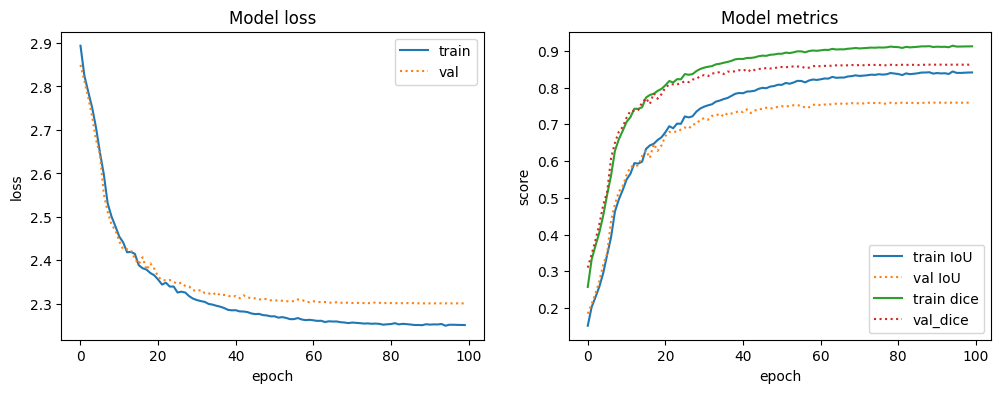

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(H['train_loss'])
plt.plot(H['test_loss'], linestyle='dotted')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(122)
plt.plot(H['train_IoU'])
plt.plot(H['test_IoU'], linestyle='dotted')
plt.plot(H['train_DC'])
plt.plot(H['test_DC'], linestyle='dotted')
plt.title('Model metrics')
plt.ylabel('score')
plt.xlabel('epoch')

plt.legend(['train IoU', 'val IoU', 'train dice', 'val_dice'], loc='lower right')

plt.show()

In [14]:
def make_prediction(model, image):
	image = torch.Tensor(image).permute((2, 0, 1)).to(DEVICE)
	image = torch.unsqueeze(image, 0)
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		predMask = model(image)
		predMask = softmax(predMask)
		predMask = torch.squeeze(predMask, 0)
		predMask = predMask.permute((1, 2, 0))
		predMask = predMask.cpu().detach().numpy()
		predMask = np.argmax(predMask, axis=-1)
		predMask = np.expand_dims(predMask, axis=-1)
		# filter out the weak predictions and convert them to integers
		return predMask.astype(np.uint8)


In [15]:
def getPredImg(image_path):     
    image = cv2.imread(image_path)
    image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    return image

def getPredMask(mask_path):
    mask = cv2.imread(mask_path)
    mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (0, 0, 0))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.expand_dims(mask, axis=-1)
    mask = encode_mask(mask)
    return mask

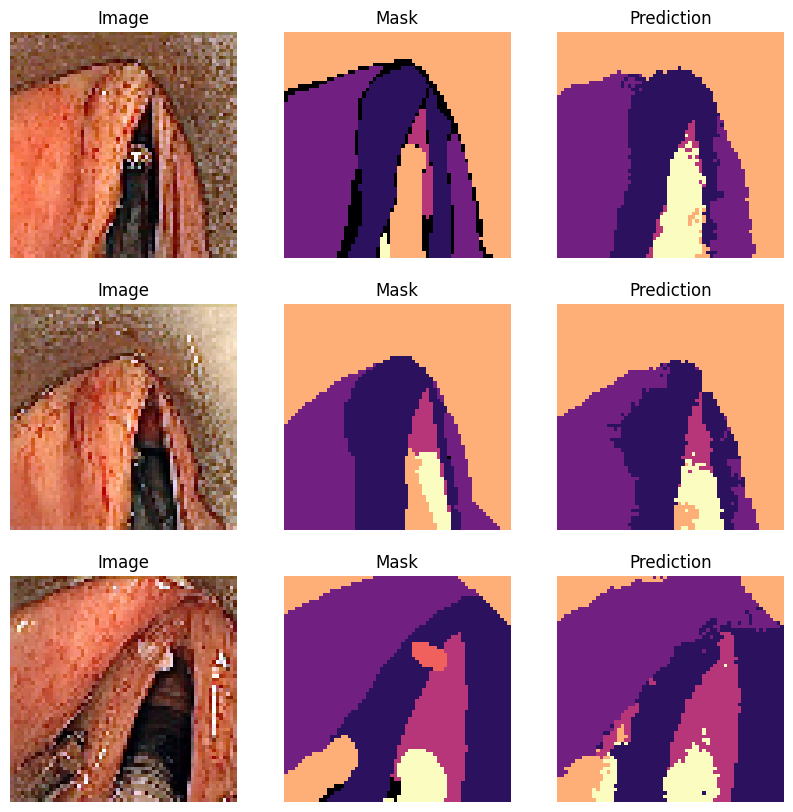

In [16]:
plt.figure(figsize=(10,10))
for i in range(3):    

    idx = random.randint(0, len(testImages) -1)
    img = getPredImg(testImages[idx])
    mask = getPredMask(testMasks[idx])
    
    plt.subplot(331 + 3*i)
    plt.imshow(img)
    plt.title('Image')
    plt.axis("off")

    mask = np.argmax(mask, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    plt.subplot(332 + 3*i)
    plt.imshow(mask, cmap='magma', norm=plt.Normalize(vmin=0, vmax=NUM_CLASSES-1))
    plt.title('Mask')
    plt.axis("off")

    pred = make_prediction(uformer, img)
    plt.subplot(333 + 3*i)
    plt.imshow(pred, cmap='magma', norm=plt.Normalize(vmin=0, vmax=NUM_CLASSES-1))
    plt.title('Prediction')
    plt.axis("off")

plt.show()

 --- 
 TFG - Alejandro García Mota